In [1]:
import sys
sys.path.append('/Users/Emily/geol3888/pygplates_rev12_python27_MacOS64')

In [2]:
#Last Updated 20180523
#Changed Appendix 3 Butterworth et al. 2016 
#Tectonic environments of South American porphyry-copper magmatism through time revealed
#by spatio-temporal data mining
#Nathaniel Butterworth, Daniel Steinberg, Dietmar Müller, Simon Williams, Andrew Merdith,
#Stephen Hardy

#Use pylab to show figures
%pylab --no-import-all inline

#Import a few different tools and libraries. See Utils_coreg for more detail.
from Utils_coreg import *

#Import the tools for machine learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
#from sklearn import cross_validation
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

#Import data processing tools
import pickle
import matplotlib.mlab as ml

Populating the interactive namespace from numpy and matplotlib
Imported pygplates.
Imported shapefile.
Imported numpy.
Imported scipy.


Each ore deposit with age in the Andes set is from Bertrand et al. (2014) is reconstructed to its geographical position at the time of its metallogenisis. We then 'coregister' the kinemtics associated with each ore deposit at that time in that location. We further reconstruct the ore deposits for 20 Myr prior to metallogenisis to capture the evolution of the kinematics that may lead to ore formation. We are then left with a matrix of parameters linked to each ore deposit through time (as listed below).

This notebook demonstrates how we take our data and apply machine learning (ML) algorithms to it. The notebook is split in two parts. Part I loads the data and wrangles it into an appropriate form for ML. Part II is the actual ML implementations and the results of the ML.

# PART I 
# Data Wrangling

### List of Variables

0 Present day longitude (degrees)

1 Present day latitude (degrees)

2 Reconstructed longitude (degrees)

3 Reconstructed latitude (degrees)


4 Age (Ma)

5 Time before mineralisation (Myr)

6 Seafloor age (Myr)


7 Segment length (km)

8 Slab length (km)

9 Distance to trench edge (km)


10 Subducting plate normal velocity (km/Myr)

11 Subducting plate parallel velocity (km/Myr)

12 Overriding plate normal velocity (km/Myr)

13 Overriding plate parallel velocity (km/Myr)

14 Convergence normal rate (km/Myr)

15 Convergence parallel rate (km/Myr)


16 Subduction polarity (degrees)

17 Subduction obliquity (degrees)

18 Distance along margin (km)

19 Subduction obliquity signed (radians)

20 Ore Deposits Binary Flag (1 or 0)

In [3]:
#####
# Develop the Data here
#####

# #Digitised pophyry copper deposits from Bertrand et al., 2014
#andeanPoints='/Users/Emily/mineralexplorationcourse/Week10/CopperDeposits/XYBer14_t2_ANDES.shp'
#print andeanPoints
#[recs,shapes,fields,Nshp]=readTopologyPlatepolygonFile(andeanPoints)

# #Run the coregistration. !!!The agegrids are hardcoded, so need to set the path in Utils_coreg.py
#from coregLoop import *
#coregData=coregLoop(recs,shapes, fields,Nshp,3)
#andes=numpy.array(coregData)

# #Load a pseudo-random set of 'copper deposits' to test against (last 3 columns in the Bertrand data set)
# #Utils_coreg.py hardcodes the random field to be at column number -1, -2, or -3
#coregData=coregLoop
#andesRand=numpy.array(coregData)


# # Read the data in
#######

andeanIN=open('/Users/Emily/mineralexplorationcourse/Week10/Muller_pickles/Muller_Bertrand_coregistered.pkl', 'rb')
andeanIN=open('/Users/Emily/mineralexplorationcourse/Week10/Muller_pickles/Muller_Bertrand_coregistered_random.pkl','rb') 
#use a random case here for sanity check
andes=pickle.load(andeanIN)
andeanIN.close()

andeanIN=open('/Users/Emily/mineralexplorationcourse/Week10/Muller_pickles/Muller_Bertrand_coregistered_random.pkl','rb')
andesRand=pickle.load(andeanIN)
andeanIN.close()

print andes.shape
print andesRand.shape

#Read in the present day subduction zone to trace back in time.
andeanIN=open('/Users/Emily/mineralexplorationcourse/Week10/Muller_pickles/Muller_Bertrand_coregistered_sampleMuller0.pkl','rb')
andesPresent=pickle.load(andeanIN)
andeanIN.close()

print andesPresent.shape

print "loaded datasets"

(377, 1, 18)
(377, 1, 18)
(313, 10, 18)
loaded datasets


In [4]:
#Remove data that has zeros for everyhting (or just where the longitude 0)

clean=numpy.where(andes[:,0,1]!=0)
andesClean = cleanCondition(clean,andes)

clean=numpy.where(andesRand[:,0,1]!=0)
andesRandClean = cleanCondition(clean,andesRand)

#Muller 13Ma and 41Ma have issues along the trench, 
#take the average of known good values for any points that did not coregister.
for i in xrange(len(andesPresent[0,:,2])):
    for j in xrange(len(andesPresent[:,0,2])):
        if andesPresent[j,i,3]==0:
            andesPresent[j,i,:]=(andesPresent[j,i+1,:]+andesPresent[j,i-1,:])/2
        #If there are nans, just replace them with the next closest timestep
        for k in xrange(len(andesPresent[0,0,:])):
            if numpy.isnan(andesPresent[j,i,k]):
                print andesClean.shape, andes.shape
                print andesRandClean.shape, andesRand.shape
                print andesPresent.shape

(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 1

(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 

(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 1

(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 1

(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 1

(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 1

(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 1

(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 1

(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 

(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 1

(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 18) (377, 1, 18)
(313, 10, 18)
(363, 1, 18) (377, 1, 18)
(363, 1, 1

In [5]:
#Now add extra parameters to the datasets
print andesPresent.shape

#Add subduction obliquity
theta=numpy.arctan(andesPresent[:,:,15]/andesPresent[:,:,14])
print theta.shape
andesPresent2 = numpy.zeros((andesPresent.shape[0],andesPresent.shape[1],andesPresent.shape[2]+2))
andesPresent2[:,:,:-2] = andesPresent
andesPresent2[:,:,-1]=theta
print andesPresent2.shape

#Add the distance along the track
distAlongTrack=numpy.cumsum(andesPresent[:,0,7])
tempDist=numpy.repeat(distAlongTrack,andesPresent2.shape[1])
tempDist=numpy.reshape(tempDist,(andesPresent2.shape[0],andesPresent2.shape[1]))

andesPresent2[:,:,-2]=tempDist

print andesPresent2.shape

(313, 10, 18)
(313, 10)
(313, 10, 20)
(313, 10, 20)


In [9]:
#Make an array that contains the list of points that match up with the distance along
#the trench of the present day day

#Make an array of lonlats that we want to search in
lonlat = numpy.r_['1,2,0',andesPresent2[:,0,0],andesPresent2[:,0,1]]

#The size of the region to find the closest point (in degrees)
region=10


#########################################
##Make this append to the andesClean data
#Make an emtpy array that stores the indexes of
indexArray=numpy.zeros((len(andesClean[:,0,0]),len(andesClean[0,:,0])))

d = numpy.zeros((andesClean.shape[0],andesClean.shape[1],andesClean.shape[2]+1))
d[:,:,:-1] = andesClean

#Loop through all the data in space and time
for ind,val in enumerate(andesClean[:,0,0]):
    for jind,valj in enumerate(andesClean[ind,:,0]):
        lonBirth=andesClean[ind,jind,0]
        latBirth=andesClean[ind,jind,1]
        
        #Now look up the nearest neighbor for each point
        index=coregPoint([lonBirth,latBirth],lonlat[:],region)
        
        if index=='inf':
            pass
        else:    
            #and save the index and distance along the track
            indexArray[ind,jind]=index
            d[ind,jind,-1]=distAlongTrack[index]
        
#Add the subduction obliquity angle data and the ore deposit formation flag data
thetad=numpy.arctan(d[:,:,15]/d[:,:,14])
d2 = numpy.ones((d.shape[0],d.shape[1],d.shape[2]+2))
d2[:,:,:-2] = d
d2[:,:,-2]=thetad


##### Random data

#########################################
##Make this append to the andesRandClean data
#Make an emtpy array that stores the indexes of
g = len(andesRandClean[:,0,0])
v = len(andesRandClean[0,:,0])
print g
print v
     
indexArray=numpy.zeros((g,v))
print indexArray

d = numpy.zeros((andesRandClean.shape[0],andesRandClean.shape[1],andesRandClean.shape[2]+1))
d[:,:,:-1] = andesRandClean

# print andesPresent2[:,0,7]
# print distAlongTrack
#Loop through all the data in space and time
for ind,val in enumerate(andesRandClean[:,0,0]):
    for jind,valj in enumerate(andesRandClean[ind,:,0]):
        lonBirth=andesRandClean[ind,jind,0]
        latBirth=andesRandClean[ind,jind,1]
        
        #Now look up the nearest neighbor for each point
        index=coregPoint([lonBirth,latBirth],lonlat[:],region)
        
        if index=='inf':
            pass
        else:    
            #and save the index and distance along the track
            indexArray[ind,jind]=index
#             print ind,jind,index
            d[ind,jind,-1]=distAlongTrack[index]

#Add the subduction obliquity angle data and the ore deposit formation flag data
thetad=numpy.arctan(d[:,:,15]/d[:,:,14])
d2Rand = numpy.zeros((d.shape[0],d.shape[1],d.shape[2]+2))
d2Rand[:,:,:-2] = d
d2Rand[:,:,-2]=thetad


#############################################
#Combine to Random and Ore Deposit datasets
d3=numpy.concatenate([d2,d2Rand])

print andesClean.shape, d2.shape
print andesRandClean.shape, d2Rand.shape

print numpy.shape(d3)

363
1
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.

Made base map
Added topo
Added shapes
Added deposit probability


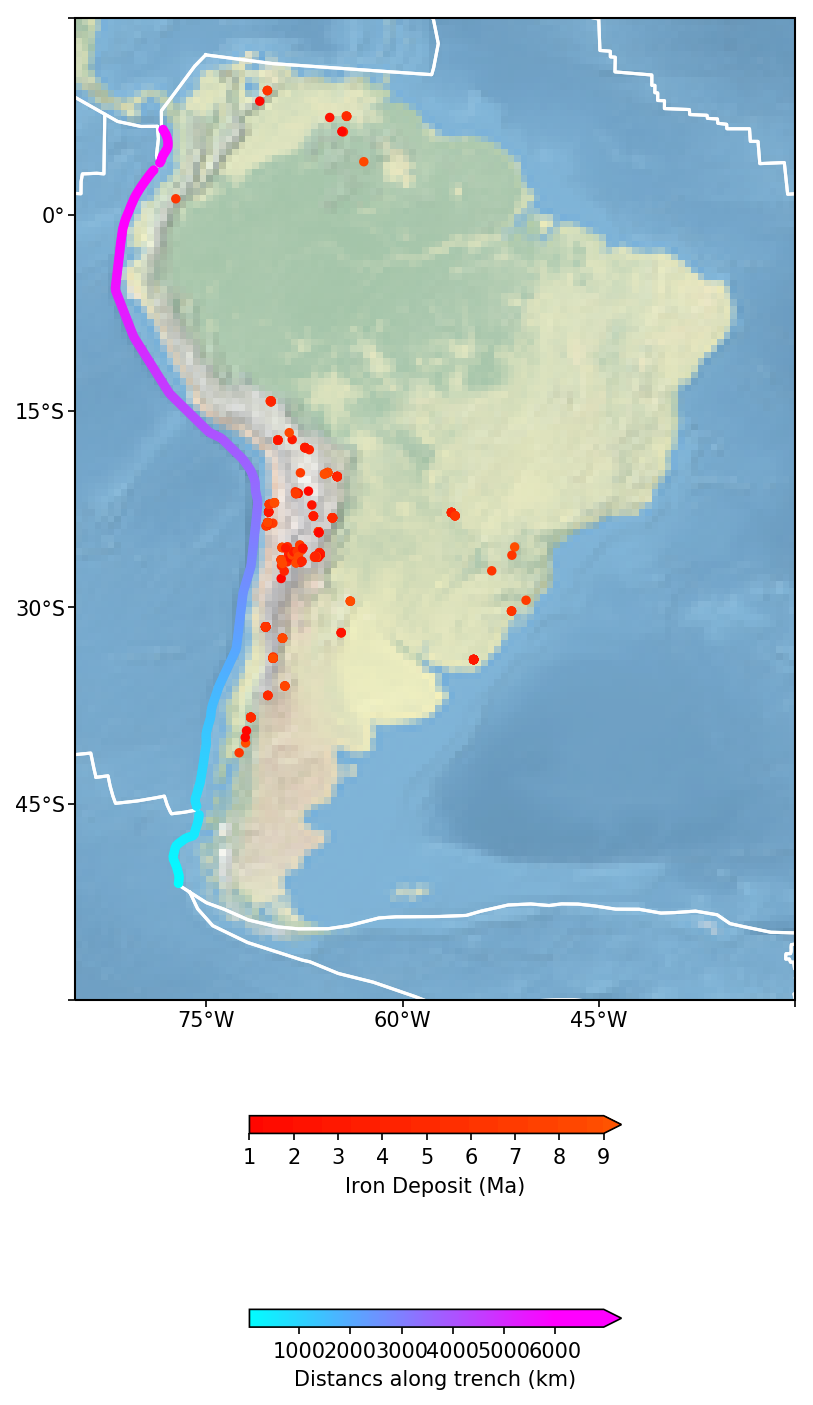

In [10]:
import cartopy.crs as ccrs

###Set up the figure
fig = plt.figure(figsize=(16,12),dpi=150)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.set_extent([-85, -30, -55, 10])
#ax.coastlines('50m', linewidth=0.8)


###Add the map grid lines and format them
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='-')

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from matplotlib import colorbar, colors

gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right = False
gl.xlines = False
gl.ylines = False
gl.xlocator = mticker.FixedLocator([-75,-60, -45,-30])
gl.ylocator = mticker.FixedLocator([-60, -45, -30, -15, 0,15])
ax.set_xticks([-75,-60, -45,-30])
ax.set_xticklabels([''])
ax.set_yticks([-60, -45, -30, -15, 0,15])
ax.set_yticklabels([''])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
#gl.xlabel_style = {'size': 15, 'color': 'gray'}
#gl.xlabel_style = {'color': 'black', 'weight': 'normal'}

print("Made base map")


print("Added topo")

###Plot shapefile polygon outlines
#Load in plate polygons for plotting
topologyFile='/Users/Emily/geol3888/pygplates_rev12_python27_MacOS64/Week10/Muller_export/topology_platepolygons_0.00Ma.shp'
[recs,shapes,fields,Nshp]=readTopologyPlatepolygonFile(topologyFile)
for i, nshp in enumerate(range(Nshp)):
    if nshp!=35 and nshp!=36 and nshp!=23:
    #These are the plates that cross the dateline and cause 
        #banding errors
        polygonShape=shapes[nshp].points
        poly=np.array(polygonShape)
        xh=poly[:,0]
        yh=poly[:,1]
        ax.plot(xh, yh, c='w',zorder=1)

print("Added shapes")

xh=andesPresent[:,0,0]
yh =andesPresent[:,0,1]
l2 = ax.scatter(xh, yh, 50, marker='.',c=distAlongTrack,cmap=plt.cm.cool,zorder=3)
cbar=fig.colorbar(l2, ax=ax, orientation="horizontal", pad=0.1, fraction=0.05, shrink=0.2,extend='max')
cbar.set_clim(0, 6000)
cbar.set_label('Distancs along trench (km)')

xh=andesClean[:,0,0]
yh =andesClean[:,0,1]
l2 = ax.scatter(xh, yh, 50, marker='.',c=andesClean[:,0,4],cmap=plt.cm.hsv,zorder=3)
cbar=fig.colorbar(l2, ax=ax, orientation="horizontal", pad=0.1, fraction=0.05, shrink=0.2,extend='max')
cbar.set_clim(0, 170)
cbar.set_label('Iron Deposit (Ma)')

print("Added deposit probability")

plt.show()

We need to merge these two datasets together, so that the cumulative sum of distance along the orignal profile is known by the ore deposit data. i.e, each ore deposits needs to find its closest associated point along the trench.

NameError: name 'd3' is not defined

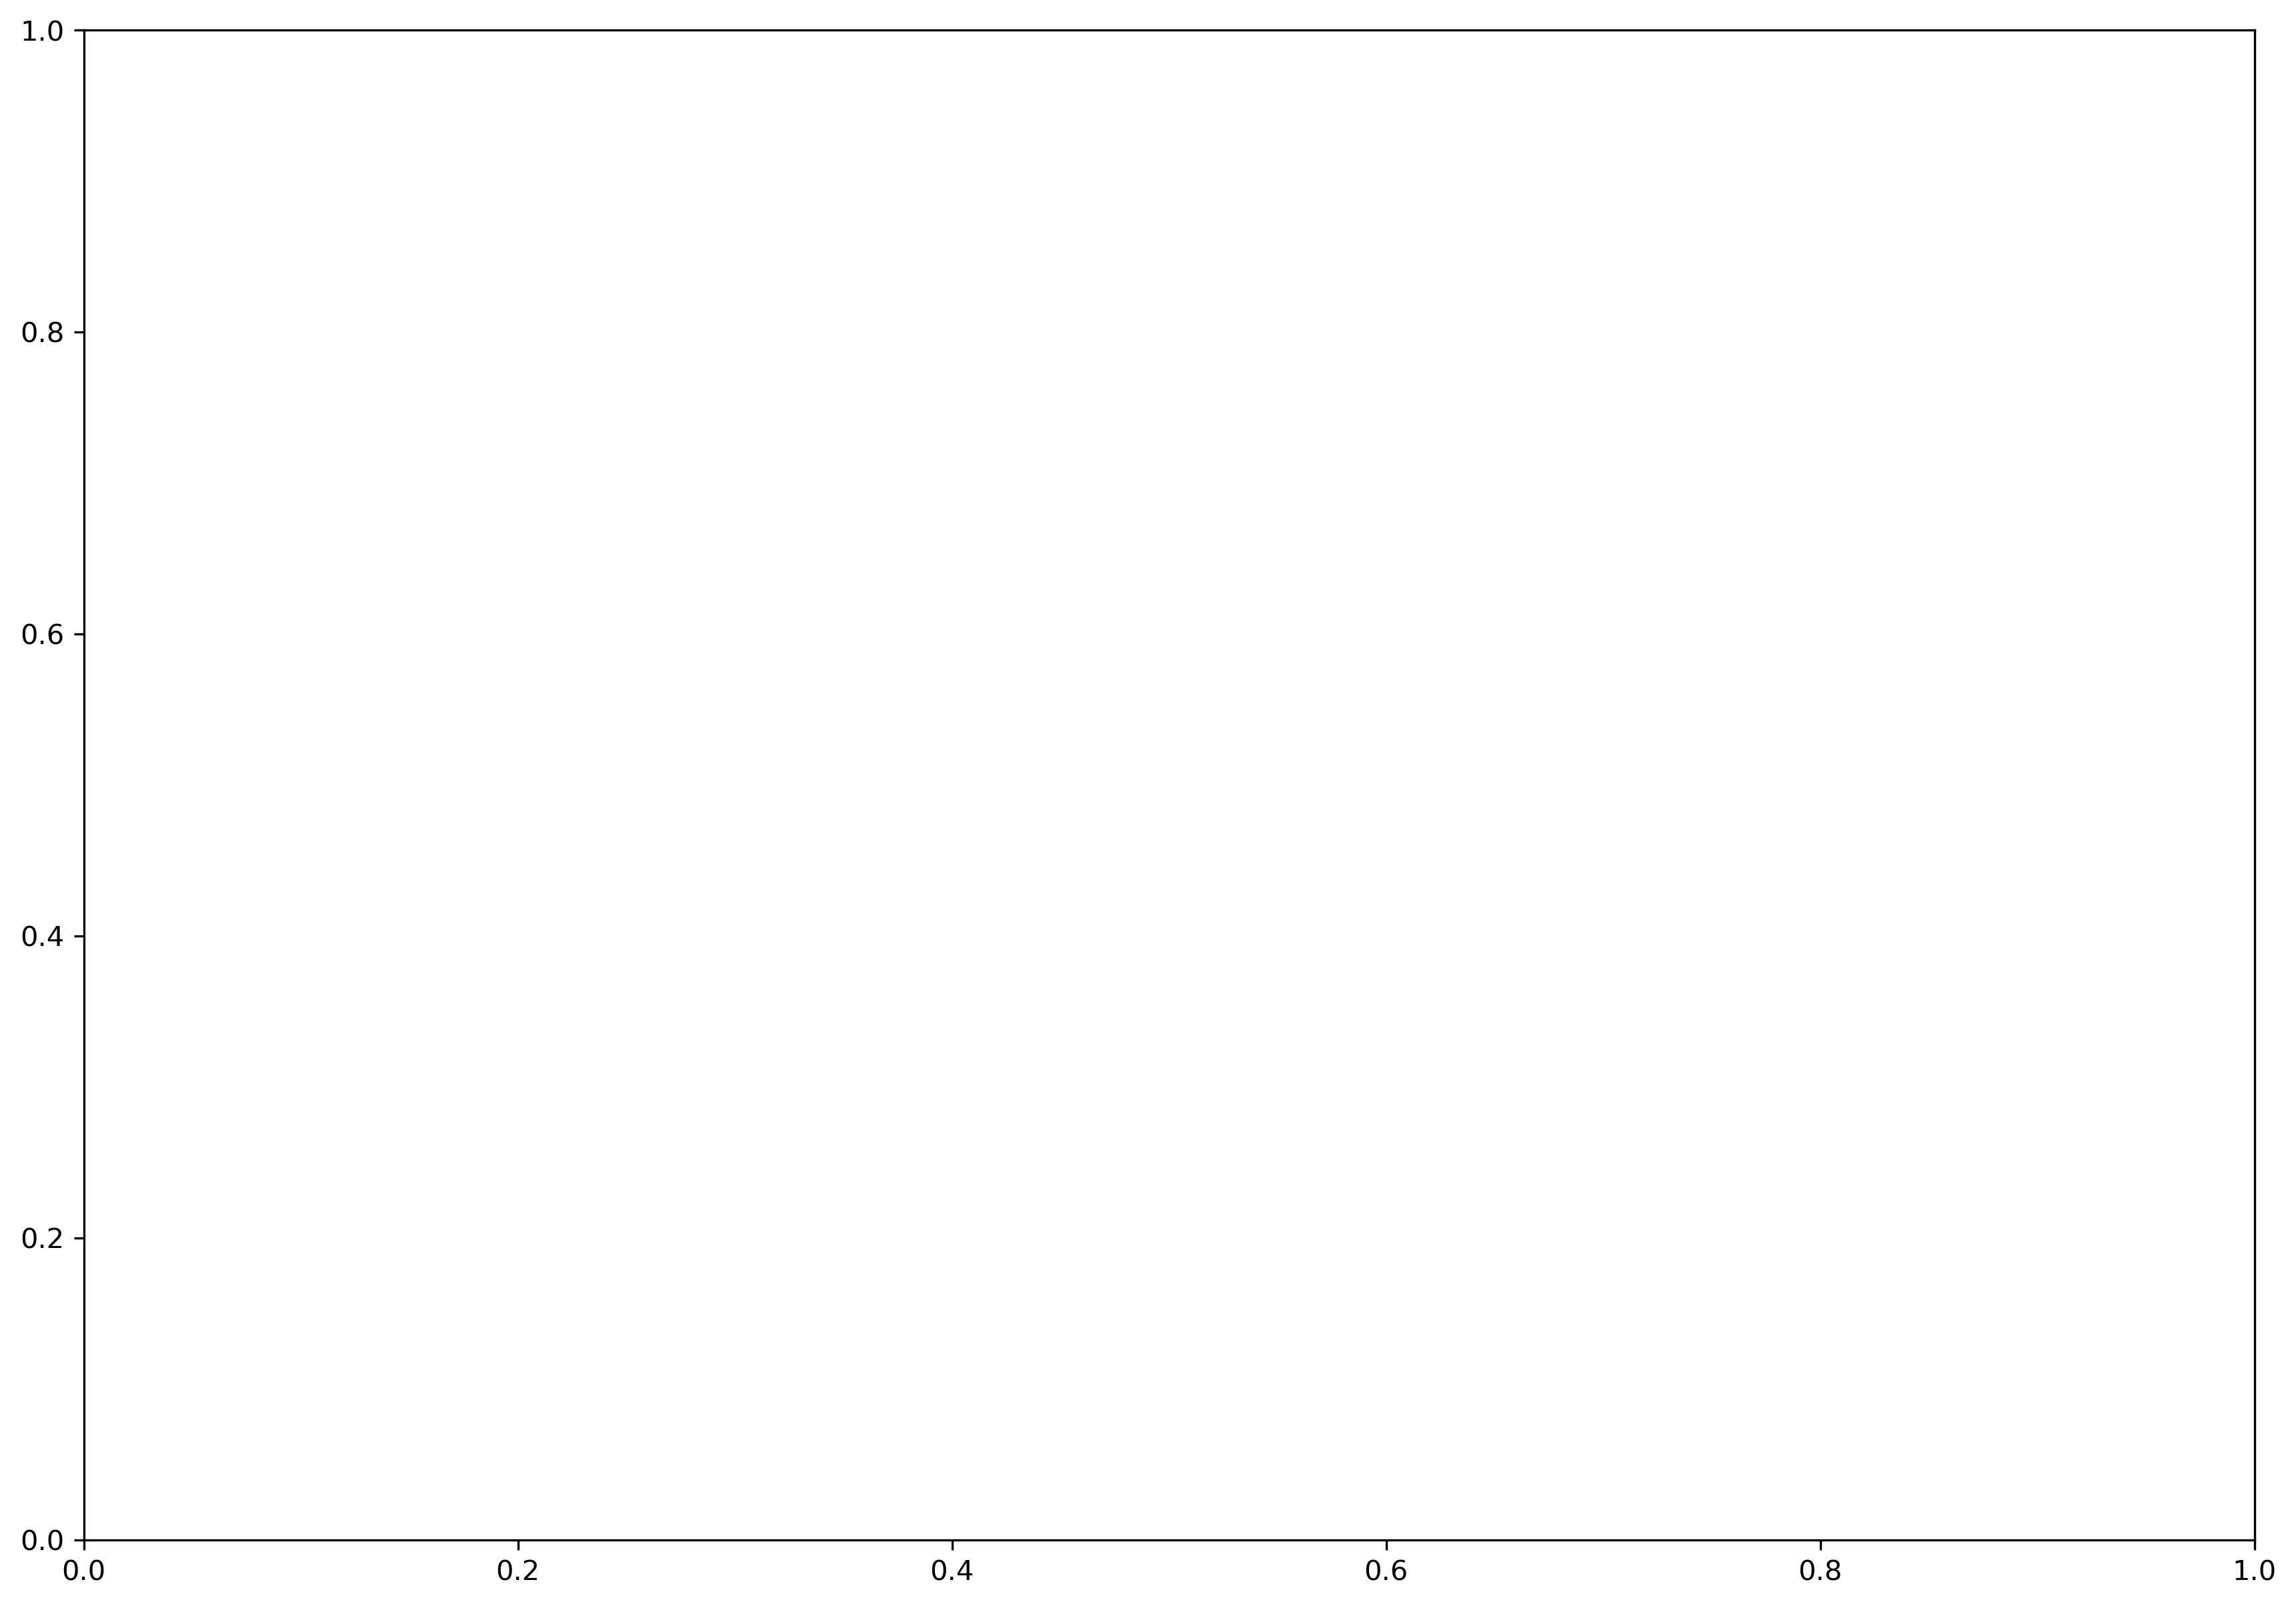

In [23]:
#Make a figure demonstrating this
fig = plt.figure(figsize=(14,10),dpi=300) 
ax = fig.add_subplot(111) 

#plot all the age and location along SAM of all the data points
ax.plot(d3[d3[:,0,-1]==1,0,4]+d3[d3[:,0,-1]==1,0,5],d3[d3[:,0,-1]==1,0,18],'ro')
    
#Plot the present day trench through time
for i in xrange(0,200,10):
    mycolor=[(i)/200.0,(i)/200.0,1-(i)/200.0]
    plt.plot(andesPresent2[:,i,4]+andesPresent2[:,i,5],andesPresent2[:,0,18],\
    #plt.plot(andesPresent[:,i,4]+andesPresent[:,i,5],range(len(andesPresent[:,i,4])),\
             color=mycolor,markersize=6, markeredgecolor='None',marker='.')

#Add details to plot
plt.legend(["Points","Present day trench"],
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,numpoints=1)

plt.title('Location and time of ore formation')
plt.ylabel('Distance along trench (km)')
plt.xlabel('Age (Ma)')

plt.xlim([0,200])
plt.ylim([0,6500])
ax.set_xticks(np.arange(0,200,10)) 
ax.set_yticks(np.arange(0,6500,500)) 
plt.grid()

plt.show()

This is the partioing of the data. 
Split the data into 500 km x 10 Myr (both these numbers are somewhat arbitrary but based on estimates for the sizes of porphyry deposits).
We focus on the tectonomagmatic parameters of each space and see if it produces an ore deposit or not.

Number of spatial domains:  13
Number of temporal domains:  17
Number of total domains:  221


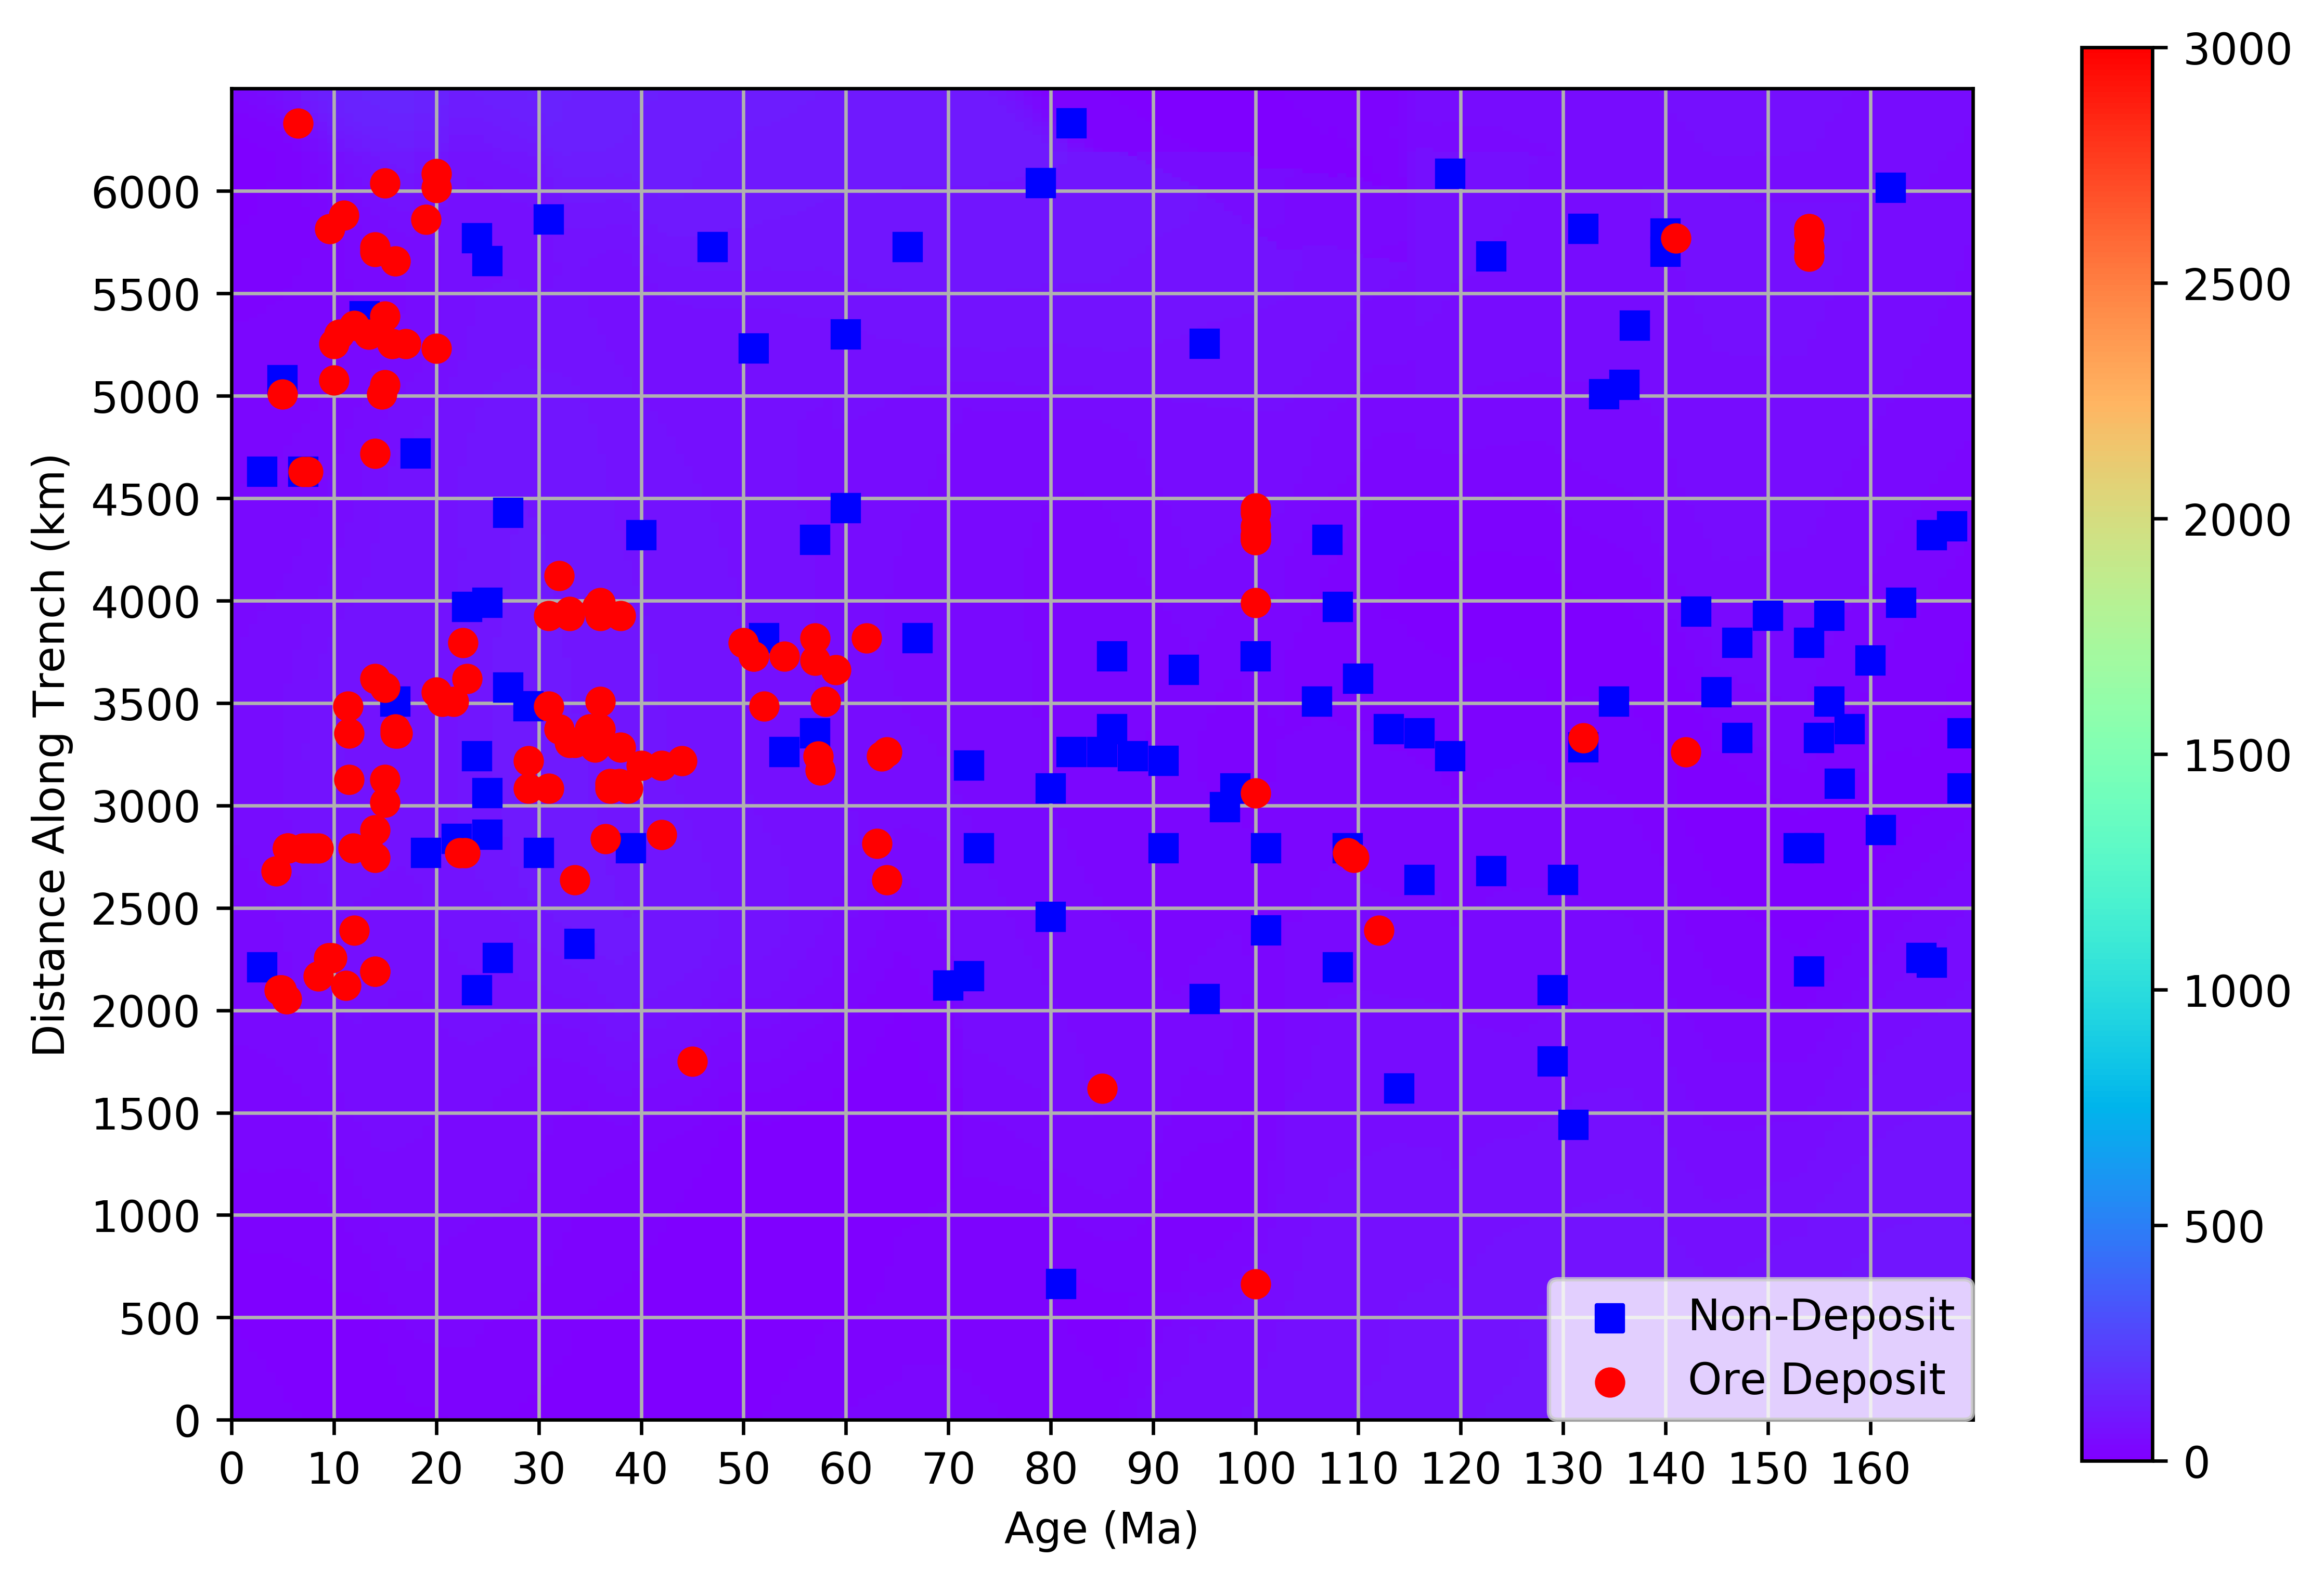

In [9]:
#Plot the combined datasets through all time and space. And (more importantly) save each 
# partioned  segment of the data, stating whether there is an ore deposit or not

#Initiliase the figure
fig = plt.figure(figsize=(9,6),dpi=600) 
ax = fig.add_subplot(111) 

#Retrieve a colour map
age_cmap=colormap_age()

#Plot the dataset, change the dataset you want to show
plt.imshow(andesPresent2[:,0:200,6],\
           #extent=[0,170,andesPresent2[-1,0,18],andesPresent2[0,0,18]],aspect=0.02,\
           extent=[0,170,6500,0],aspect=0.02,\
#            cmap=age_cmap,vmin=0,vmax=200) #Seafloor age 6
#            cmap=plt.cm.RdBu_r,vmin=-200,vmax=200) #Convergence Rate 14
#            cmap=plt.cm.PuOr,vmin=-90,vmax=90) #Subduction Obliquity 17 degs, 19 rads
           cmap=plt.cm.rainbow,vmin=0,vmax=3000) #Distance from Plate Boundary 9


#plt.clim(0,70)
plt.gca().invert_yaxis()
cbar=plt.colorbar()
cbar.location='bottom'
# cbar.set_label('Age of Subducting Lithosphere (Myr)') #6
# cbar.set_label('Orthogonal Plate Convergence (km/Myr)') #14
# cbar.set_label('Subduction Obliquity (degrees)') #17 degs 19 signed rads
# cbar.set_label('Distance to trench edge/plate boundary (km)') #9


#Make an empty array to store each segmented dataset
partionedData=[]

#Now plot where all the Ore deposits fall
#make an array for coloring the points
k=0

#Plot the non-deposit, 'random' data 
data1=d3[d3[:,0,20]==0,0,4]+d3[d3[:,0,20]==0,0,5] 
data2=d3[d3[:,0,20]==0,0,18]

for i in xrange(0,len(data1),1):
    #mycolor=[0.6,0.9,(i+0.1)/float(len(data1))]
    ax.plot(data1[i],data2[i],\
             color='b',marker='s',linestyle='None',lw=0.)

#Plot the ore deposit data 
data1=d3[d3[:,0,20]==1,0,4]+d3[d3[:,0,20]==1,0,5] 
data2=d3[d3[:,0,20]==1,0,18]

for i in xrange(0,len(data1),1):
    #mycolor=[(i+0.1)/float(len(data1)),(i+0.1)/float(len(data1)),(i+0.1)/float(len(data1))]
    ax.plot(data1[i],data2[i],\
             color='r',marker='o',linestyle='None',lw=0.)
    
    #print d3[i,0,6], mycolor #Check with parameter colouring
    


##THIS IS WHERE THE SPATIO-TEMPORAL BIN PARAMETERS ARE SET

print "Number of spatial domains: ", len(xrange(0,6500,500)) 
print "Number of temporal domains: ",len(xrange(0,170,10))
print "Number of total domains: ", len(xrange(0,6500,500))*len(xrange(0,170,10))

#Change the extent of the next 2 for-loops and iterators to change resolution of intervals and impose space-time restrictions
#Loop through the 6500km length of the Andean Margin in 500km increments #max length is actually 6107km
for i in xrange(0,6100,500):
    j=i+500
    
    #Loop through all time in 10Myr increments, change here to restrict time
    for t1 in xrange(0,170,10):
        t2=t1+10
        
        #Extract just the parts of the data we want
        bin1=numpy.where(d3[:,0,18]>=i)
        andesTemp1 = cleanCondition(bin1,d3)
        bin2=numpy.where(andesTemp1[:,0,18]<j)
        andesTemp2 = cleanCondition(bin2,andesTemp1)
        bin3=numpy.where(andesTemp2[:,0,4]>=t1)
        andesTemp3 = cleanCondition(bin3,andesTemp2)
        bin4=numpy.where(andesTemp3[:,0,4]<t2)
        
        andesData = cleanCondition(bin4,andesTemp3)
        
        bin1=numpy.where(andesPresent2[:,0,18]>=i)
        andesTemp1 = cleanCondition(bin1,andesPresent2)
        bin2=numpy.where(andesTemp1[:,0,18]<j)
        andesTemp2 = cleanCondition(bin2,andesTemp1)
                
        andesProfile = andesTemp2[:,t1:t2,:]

        andesProfile = numpy.nanmean(numpy.nanmean(andesProfile,axis=0),axis=0)
        
        #Check if that domain has or deposit or not.
        if len(andesData) > 0:
            #If it does store a 1
            if andesData[0][0][-1]==1:
                partionedData.append(numpy.append(andesProfile,1))
            #If it does not store a 0
            else:
                partionedData.append(numpy.append(andesProfile,0))
        
        #If it does not store a 0        
        else:
            partionedData.append(numpy.append(andesProfile,0))
        


#Label the plot
plt.ylabel('Distance Along Trench (km)')
plt.xlabel('Age (Ma)')
plt.xlim([0,170])
#plt.ylim([-50,10])
plt.ylim([0,6500])
ax.set_xticks(np.arange(0,170,10)) 
ax.set_yticks(np.arange(0,6500,500)) 
plt.grid()

#Make a legend
Z = [[-10,-10],[-10,-10]] #With dummy variables
p1=ax.scatter(Z[0],Z[1],marker='s',c='b')
p2=ax.scatter(Z[0],Z[1],marker='o',c='r')
ax.legend([p1,p2],["Non-Deposit","Ore Deposit"],
           bbox_to_anchor=(1, 0), loc=4, borderaxespad=0.,numpoints=1)

plt.show()

In [10]:
#Convert to a numpy array for easier manipulation and plotting
aaa=numpy.array(partionedData)

print "Shape of data array: ", aaa.shape

#Number of 'positive' and 'negative' examples
print "Positive (deposits) examples: ",np.shape(aaa[aaa[:,20]==1,:])
print "Negative (non-deposits) examples: ",np.shape(aaa[aaa[:,20]==0,:])

#Check for NAN..
print "Are there NANs?", numpy.isnan(numpy.sum(aaa))

Shape of data array:  (221, 21)
Positive (deposits) examples:  (42, 21)
Negative (non-deposits) examples:  (179, 21)
Are there NANs? False


# PART II 
# Machine Learning
Now we use our datasets to determine what tectonomagmatic parameters are related to ore formation. We use Support Vector Machines and Random Forrest classification methods. This notebook shows the two methods of data analysis, either looking at the general area of ore formation, or considering each ore formation point individually.


## Area of formation (Partioned Data)

#### Split the data into testing and training sets.
With the "training" set we learn which parameters are important, and we test the validity of this with the "testing" set.

In [11]:
#Put the data into the correct format

#Get the parameters we want to include in the ML, indicies are from the List of Variables
params=[6,9,14,17] 
# params=[6,9,10,11,12,13,14,15,16,17]
datalength=len(params)

## Recombine the features and the classification vectors. #Save the temporal-spatial parameters too for plotting purposes.
andesData = numpy.c_[preprocessing.scale(aaa[:,params]),aaa[:,5],aaa[:,18],aaa[:,20]]

##OR

#Make a dataset for cross validation
#andesTraining = d3[:,0,:]
#Time Restricted Set
# andesTraining=d3[d3[:,0,4]<70,0,:]
#andesData = numpy.c_[preprocessing.scale(andesTraining[:,params]),andesTraining[:,4],andesTraining[:,18],andesTraining[:,20]]

#Do a 80/20 split of the data  to be used to make an example fit of the data
andesTrain, andesTest,  = train_test_split(\
       andesData, test_size=0.2, random_state=1)

print "Shape of data array: ", andesData.shape


Shape of data array:  (221, 7)


In [12]:
print 'Make the classifiers'
print 'RF...'
#create and train the random forest
#multi-core CPUs can use: rf = RandomForestClassifier(n_estimators=100, n_jobs=2)
#n_estimators use between 64-128 doi: 10.1007/978-3-642-31537-4_13
rf = RandomForestClassifier(n_estimators=128, n_jobs=1,class_weight=None).fit(andesData[:,0:datalength],andesData[:,-1])
print "Done RF"
scores = cross_val_score(rf, andesData[:,0:datalength],andesData[:,-1], cv=10)
print "RF Scores: ",scores
print "SCORE Mean: %.2f" % np.mean(scores), "STD: %.2f" % np.std(scores)


print 'SVC...'
clf = SVC(probability=True,class_weight=None).fit(andesData[:,0:datalength],andesData[:,-1])
print "Done SVC"
scores = cross_val_score(clf, andesData[:,0:datalength],andesData[:,-1], cv=10)
print "SVM/SVC Scores: ",scores
print "SCORE Mean: %.2f" % np.mean(scores), "STD: %.2f" % np.std(scores)

Make the classifiers
RF...
Done RF
RF Scores:  [0.7826087  0.91304348 0.90909091 0.86363636 0.72727273 0.86363636
 0.77272727 0.77272727 0.86363636 0.80952381]
SCORE Mean: 0.83 STD: 0.06
SVC...
Done SVC
SVM/SVC Scores:  [0.7826087  0.91304348 0.90909091 0.86363636 0.77272727 0.86363636
 0.77272727 0.81818182 0.81818182 0.80952381]
SCORE Mean: 0.83 STD: 0.05


/anaconda3/envs/py2GEOL/lib/python2.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [13]:
andeanIN=open(r'Muller_Bertrand_coregistered_sampleMuller0.pkl','rb')


#This sets the output names, change for appropriate timestep
prefix="0"

andesPresent=pickle.load(andeanIN)
andeanIN.close()

#Now add extra parameters to the datasets
print andesPresent.shape

for i in xrange(len(andesPresent[0,:,2])):
    for j in xrange(len(andesPresent[:,0,2])):
        if andesPresent[j,i,3]==0:
            andesPresent[j,i,:]=(andesPresent[j,i+1,:]+andesPresent[j,i-1,:])/2
        #If there are nans, just replace them with the next closest timestep
        for k in xrange(len(andesPresent[0,0,:])):
            if numpy.isnan(andesPresent[j,i,k]):
                andesPresent[j,i,k]=andesPresent[j,i+1,k]


#Add subduction obliquity
theta=numpy.arctan(andesPresent[:,:,15]/andesPresent[:,:,14])
print theta.shape
andesPresent2 = numpy.zeros((andesPresent.shape[0],andesPresent.shape[1],andesPresent.shape[2]+2))
andesPresent2[:,:,:-2] = andesPresent
andesPresent2[:,:,-1]=theta
print andesPresent2.shape

#Add the distance along the track
distAlongTrack=numpy.cumsum(andesPresent[:,0,7])
tempDist=numpy.repeat(distAlongTrack,andesPresent2.shape[1])
tempDist=numpy.reshape(tempDist,(andesPresent2.shape[0],andesPresent2.shape[1]))

andesPresent2[:,:,-2]=tempDist

print andesPresent2.shape

IOError: [Errno 2] No such file or directory: 'Muller_Bertrand_coregistered_sampleMuller0.pkl'

In [ ]:
aaa=andesPresent2.reshape(len(andesPresent2[:,0,0])*len(andesPresent2[0,:,0]),len(andesPresent2[0,0,:]))
print aaa.shape

andesSuite = numpy.c_[preprocessing.scale(aaa[:,params]),\
                      aaa[:,0],aaa[:,1],\
                      aaa[:,2],aaa[:,3],\
                      aaa[:,5],aaa[:,18]]

In [ ]:
#Apply the trained ML to our gridded data to determine the probabilities at each of the points
print 'RF...'
pRF=numpy.array(rf.predict_proba(andesSuite[:,0:datalength]))
print "Done RF"

print 'SVC...'
pSVC=numpy.array(clf.predict_proba(andesSuite[:,0:datalength]))
print "Done SVC"


In [ ]:
#Save out the grids for all of the timesteps.
#And make a figure
fig = plt.figure(figsize=(16,12),dpi=600) 
ax = fig.add_subplot(111)

#Now because the data was formatted to a long list for the ML and we want individual timesteps
# we can loop through each timestep to output each timeslice indicidually
for t in xrange(230):
    #Pull out just the current time
    firstInd=(andesSuite[:,-2] < (t+1))
    secondInd=(andesSuite[:,-2] > (t-1))
    finalInd=numpy.all([secondInd,firstInd],axis=0)

    andesTime=andesSuite[finalInd,:]

    #RF
    #Find the probability for these times
    proba = pRF[finalInd,1]
    #Save out lat, lon, and probability
    outputfile = "probgrids/probgrid"+prefix+"RF_"+str(t)+".xyz"
#     numpy.savetxt(outputfile,(numpy.c_[andesTime[:,-4],andesTime[:,-3], proba]),delimiter=" ",fmt='%1.5f')

    #And plot it
    plt.scatter(andesTime[:,-2],andesTime[:,-3],c=proba,s=10,marker='o',edgecolor='none')
    
    #SVC repeat as above
    proba = pSVC[finalInd,1]
    outputfile = "probgrids/probgrid"+prefix+"SVC_"+str(t)+".xyz"
#     numpy.savetxt(outputfile,(numpy.c_[andesTime[:,-4],andesTime[:,-3], proba]),delimiter=" ",fmt='%1.5f')
    
#     plt.scatter(andesTime[:,-2],andesTime[:,-3],c=proba,s=10,marker='o',edgecolor='none')
    
    #scale the colour at each step for our plot
    plt.clim([0,1])


#Just for colorbar, 
firstInd=(andesSuite[:,-2] < (t))
secondInd=(andesSuite[:,-2] > (t-2))
finalInd=numpy.all([secondInd,firstInd],axis=0)
andesTime=andesSuite[finalInd,:]
proba = pRF[finalInd,1]
plt.scatter(andesTime[:,-2],andesTime[:,-3],c=proba,s=10,marker='o',edgecolor='none')
cbar=plt.colorbar()
cbar.set_label('Predicted probablity of Ore Deposit')
plt.clim([0,1])


#Plot the non-deposit data 
data1=d3[d3[:,0,20]==0,0,4]
data2=d3[d3[:,0,20]==0,0,3]

plt.scatter(data1,data2,c='b',marker='s')


#Plot the ore-deposit data 
data1=d3[d3[:,0,20]==1,0,4]
data2=d3[d3[:,0,20]==1,0,3]

plt.scatter(data1,data2,c='r',marker='o')


#Add details to the plot
plt.title('Random Forest')
# plt.title('SVC/SVM')
plt.ylabel('Latitude (degrees)')
plt.xlabel('Age (Ma)')
plt.xlim([0,230])
plt.ylim([-70,10])


#Make a legend
Z = [[-10,-10],[-10,-10]] #With dummy variables
p1=ax.scatter(Z[0],Z[1],marker='s',c='b')
p2=ax.scatter(Z[0],Z[1],marker='o',c='r')
ax.legend([p1,p2],["Training Non-Deposit","Training Ore Deposit"],
           bbox_to_anchor=(1, 0.935), loc=4, borderaxespad=0.,numpoints=1)

plt.show()


# SVM
Use Support Vector Machines to learn which parameters are important.

In [ ]:
#Make the classifier
clf = SVC(probability=True,verbose=True,cache_size=1000,class_weight=None)


#Now make a single classification for plotting and typicla results
#Train the classifier by fitting the parameters (features) to known results (targets/classes)
clf.fit(andesTrain[:,0:-3], andesTrain[:,-1])

print "Prediction-testing set (expected result):"
print andesTest[:,-1]

print "Prediction of test (actual result):"
print clf.predict(andesTest[:,0:-3])

#Save the values of prediction
p=numpy.array(clf.predict_proba(andesTest[:,0:-3]))

#Get a single score out for the data
svmParams=clf.score(andesTest[:,0:-3], andesTest[:,-1])
print "Single result:"
print svmParams

# print clf.support_vectors_

###
#Now get a cross-fold validation score using all subsets of the data
scores = cross_val_score(clf, andesData[:,0:-3], andesData[:,-1], cv=5)

print "Cross fold validation results:"
print scores

#print clf.n_support_

# SVM Typical Result

In [ ]:
#Make some plots of typical results

#Create vectors of the prediced and actual results
subset=andesTrain[andesTrain[:,-1]==1]
subsetpredict=andesTest[andesTest[:,-1]==1]
subsetNegative=andesTrain[andesTrain[:,-1]==0]
subsetpredictNegative=andesTest[andesTest[:,-1]==0]

#Create a time-space map showing when and where along the margin an ore deposit may have 
#formed

#Create a grid to map the ML results to
grid_x, grid_y = np.meshgrid(np.linspace(0,200,100),np.linspace(0,6500,65))
#Retrieve the ML scores
values = p[:,1].flatten()
print "Number of points used for testing: ", np.shape(values)

#Now grid the data
grid_z1 = ml.griddata(andesTest[:,-3].flatten(),\
                      andesTest[:,-2].flatten(),\
                      values, grid_x, grid_y,interp='linear')

print "Shape of grid:", np.shape(grid_z1)

#Plot the new grid
fig = plt.figure(figsize=(8,6),dpi=600)
plt.imshow(grid_z1,origin='lower',\
           extent=[0,200,0,6500],aspect=0.03)

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

cbar=plt.colorbar()
cbar.set_label('Predicted probablity of porphyry magmatism')


#Plot each of the result vectors
#Plot the testing data
p1,=plt.plot(subsetpredict[:,-3],subsetpredict[:,-2],'ro')
p2,=plt.plot(subsetpredictNegative[:,-3],subsetpredictNegative[:,-2],'bD')

#Plot the training data
p3,=plt.plot(subset[:,-3],subset[:,-2],'rp')
p4,=plt.plot(subsetNegative[:,-3],subsetNegative[:,-2],'bs')

#Create the legend
plt.legend([p1,p2,p3,p4],\
           ["Test Positive","Test Negative","Training Positive","Training Negative"],
           bbox_to_anchor=(2, 1), loc=1, borderaxespad=0.,numpoints=1)

#Adjust the plot
plt.clim([0,1])
plt.xlim([0,180])
plt.ylim([0,6500])
ax = plt.axes()
ax.set_xticks(np.arange(0,180,20)) 
ax.set_yticks(np.arange(0,6500,1000))

plt.ylabel('Distance Along Trench (km)')
plt.xlabel('Age (Ma)')
plt.title('SVM')

plt.show()

print "Five-fold cross validation scores: ", scores
print 'SCORE Mean: %.2f' % np.mean(scores), 'STD: %.2f' % np.std(scores)

# Random Forest Classification
Try a Random Forest classification also

In [ ]:
print 'Running...'
#create and train the random forest
#multi-core CPUs can use: rf = RandomForestClassifier(n_estimators=100, n_jobs=2)
#n_estimators use between 64-128 doi: 10.1007/978-3-642-31537-4_13
rf = RandomForestClassifier(n_estimators=128, n_jobs=1,class_weight=None)


#Now make a single classification for plotting and typical results
print 'Fitting...'
rf.fit(andesTrain[:,0:-3], andesTrain[:,-1])

#predicted_probs = [[index + 1, x[1]] for index, x in enumerate(rf.predict_proba(testingSet))]

print 'Score of test data: ', rf.score(andesTest[:,0:-3], andesTest[:,-1])
p=numpy.array(rf.predict_proba(andesTest[:,0:-3]))
#q=numpy.array(predicted_probs)

#The Random Forest method allows us to determine what parameters preferentially optimised the test score.
print "Feature Importance: ", rf.feature_importances_

###
#Get a cross-fold validation score using all subsets of the data
scores = cross_val_score(rf, andesData[:,0:-3], andesData[:,-1], cv=5)

print "Five-fold cross validation scores: ", scores

In [ ]:
#Plot of feature importance
paramLabels=["Seafloor Age","Distance to Trench Edge","Subducting Plate Normal", "Subducting Plate Parallel",\
             "Overriding Plate Normal", "Overriding Plate Parallel",\
             "Convergence Rate","Convergence Parallel",\
             "Subduction Polarity", "Subduction OBliquity"]
        
paramLabels=["Seafloor Age","Distance to Trench Edge","Convergence Rate", "Subduction OBliquity"]

fig, ax = plt.subplots()

#rects=ax.bar([0,1,2,3,4,5,6,7,8,9,10],rf.feature_importances_)
# rects=ax.bar([0,1,2,3,4,5,6,7,8,9],rf.feature_importances_)
# rects=ax.bar([0,1,2,3,4,5,6,7,8],rf.feature_importances_)
# rects=ax.bar([0,1,2,3,4,5,6,7],rf.feature_importances_)
# rects=ax.bar([0,1,2,3,4,5,6],rf.feature_importances_)
# rects=ax.bar([0,1,2,3,4,5],rf.feature_importances_)
# rects=ax.bar([0,1,2,3,4],rf.feature_importances_)
rects=ax.bar([0,1,2,3],rf.feature_importances_)

#print len(rf.feature_importances_)

#Set the location of the tick marks
# ax.set_xticks([-0.8,-0.8,0.2,1.2,2.2,3.4,4.8,5.4,6.6,7.4])
ax.set_xticks([0.2,0.8,2.0,3.0])

# plt.ylim([0,0.35])

ax.set_xticklabels(paramLabels,rotation=45)
ax.set_ylabel('Feature Importance')

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

plt.show()

print "Feature Importance: ", rf.feature_importances_

In [ ]:
#Make some plots of typical results

#Create vectors of the prediced and actual results
subset=andesTrain[andesTrain[:,-1]==1]
subsetpredict=andesTest[andesTest[:,-1]==1]
subsetNegative=andesTrain[andesTrain[:,-1]==0]
subsetpredictNegative=andesTest[andesTest[:,-1]==0]

#Create a time-space map showing when and where along the margin an ore deposit may have 
#formed

#Create a grid to map the ML results to
grid_x, grid_y = np.meshgrid(np.linspace(0,200,100),np.linspace(0,6500,65))
#Retrieve the ML scores
values = p[:,1].flatten()
print "Number of points with an ML score: ", np.shape(values)
print np.shape(andesTest[:,-3].flatten())
print np.shape(andesTest[:,-2].flatten())
#Now grid the data
grid_z1 = ml.griddata(andesTest[:,-3].flatten(),\
                      andesTest[:,-2].flatten(),\
                      values, grid_x, grid_y,interp='linear')

print "Shape of grid:", np.shape(grid_z1)

#Plot the new grid
fig = plt.figure(figsize=(8,6),dpi=600)
plt.imshow(grid_z1,origin='lower',\
           extent=[0,200,0,6500],aspect=0.03)

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

cbar=plt.colorbar()
cbar.set_label('Predicted probablity of porphyry magmatism')


#Plot each of the result vectors
#Plot the testing data
p1,=plt.plot(subsetpredict[:,-3],subsetpredict[:,-2],'ro')
p2,=plt.plot(subsetpredictNegative[:,-3],subsetpredictNegative[:,-2],'bD')

#Plot the training data
p3,=plt.plot(subset[:,-3],subset[:,-2],'rp')
p4,=plt.plot(subsetNegative[:,-3],subsetNegative[:,-2],'bs')

#Create the legend
plt.legend([p1,p2,p3,p4],\
           ["Test Positive","Test Negative","Training Positive","Training Negative"],
           bbox_to_anchor=(2, 1), loc=1, borderaxespad=0.,numpoints=1)

#Adjust the plot
plt.clim([0,1])
plt.xlim([0,180])
plt.ylim([0,6500])
ax = plt.axes()
ax.set_xticks(np.arange(0,180,20)) 
ax.set_yticks(np.arange(0,6500,1000))

plt.ylabel('Distance Along Trench (km)')
plt.xlabel('Age (Ma)')
plt.title('RF')

plt.show()

print "Five-fold cross validation scores: ", scores
print 'SCORE Mean: %.2f' % np.mean(scores), 'STD: %.2f' % np.std(scores)

# Point of formation data
Same methods as above, however the data is formatted slightly differently so we must rewrite the functions used.

### Split the data into testing and training sets.
With the "training" set we learn which parameters are important, and we test the validity of this with the "testing" set.

In [ ]:
#Make a dataset for cross validation
andesTraining = d3[:,0,:]
#Time Restricted Set
# andesTraining=d3[d3[:,0,4]<70,0,:]

print "Size of data set: ", andesTraining.shape

#Recombine the features and the classification vectors. #Save the temporal-spatial parameters too for plotting purposes.
params=[6,9,14,17] #indicies from List of Variables
# params=[6,9,10,11,12,13,14,15,16,17]
andesData = numpy.c_[preprocessing.scale(andesTraining[:,params]),andesTraining[:,4],andesTraining[:,18],andesTraining[:,20]]

#Do a 80/20 split of the data  to be used to make an example fit of the data
andesTrain, andesTest,  = train_test_split(\
       andesData, test_size=0.2, random_state=1)

print "Shape of data array: ", andesData.shape

#Number of 'positive' and 'negative' examples
print "Positive (deposits) examples: ",np.shape(andesTraining[andesTraining[:,20]==1,:])
print "Negative (non-deposits) examples: ",np.shape(andesTraining[andesTraining[:,20]==0,:])

print "Are there NANs?", numpy.isnan(numpy.sum(andesData))

# SVM

In [ ]:
#Make the classifier
clf = SVC(probability=True,class_weight=None)

#Train the classifier by fitting the parameters (features) to know results (targets)
clf.fit(andesTrain[:,0:-3], andesTrain[0:,-1])

print "Prediction-testing set (expected result):"
print andesTest[0:,-1]

print "Prediction of test (result):"
print clf.predict(andesTest[:,0:-3])

#Save the values of prediction
p=numpy.array(clf.predict_proba(andesTest[:,0:-3]))

#To get a score out for the data
svmParams=clf.score(andesTest[:,0:-3],andesTest[0:,-1])
print "Single result:"
print svmParams

#Get a cross-fold validation score using all subsets of the data
scores = cross_val_score(clf, andesData[:,0:-3], andesData[:,-1], cv=5)

print "Cross fold validation results:"
print scores

# SVM Results

In [ ]:
#Make some plots of typical results

#Create vectors of the prediced and actual results
subset=andesTrain[andesTrain[:,-1]==1]
subsetpredict=andesTest[andesTest[:,-1]==1]
subsetNegative=andesTrain[andesTrain[:,-1]==0]
subsetpredictNegative=andesTest[andesTest[:,-1]==0]

#Create a time-space map showing when and where along the margin an ore deposit may have formed

#Create a grid to map the ML results to
grid_x, grid_y = np.meshgrid(np.linspace(0,200,100),np.linspace(0,6500,500))
#Retrieve the ML scores
values = p[:,1].flatten()
print "Number of points with an ML score: ", np.shape(values)

grid_z1 = ml.griddata(andesTest[:,-3].flatten(),\
                      andesTest[:,-2].flatten(),\
                      values, grid_x, grid_y,interp='linear')

print "Shape of grid:", np.shape(grid_z1)

fig = plt.figure(figsize=(8,6),dpi=600)
plt.imshow(grid_z1,origin='lower',\
           extent=[0,200,0,6500],aspect=0.03)

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

cbar=plt.colorbar()
cbar.set_label('Predicted probablity of porphyry magmatism')

#Plot each of the result vectors
#negative testing
p2,=plt.plot(subsetpredictNegative[:,-3],subsetpredictNegative[:,-2],'bD')

#negative training
p4,=plt.plot(subsetNegative[:,-3],subsetNegative[:,-2],'bs')

#positive training
p3,=plt.plot(subset[:,-3],subset[:,-2],'rp')

#positive testing
p1,=plt.plot(subsetpredict[:,-3],subsetpredict[:,-2],'ro')

plt.legend([p1,p2,p3,p4],\
           ["Test Positive","Test Negative","Training Positive","Training Negative"],
           bbox_to_anchor=(2, 1), loc=1, borderaxespad=0.,numpoints=1)



#Adjust the plot
plt.clim([0,1])
plt.xlim([0,180])
plt.ylim([0,6500])
ax = plt.axes()
ax.set_xticks(np.arange(0,180,20)) 
ax.set_yticks(np.arange(0,6500,1000))

plt.ylabel('Distance Along Trench (km)')
plt.xlabel('Age (Ma)')
plt.title('SVM')

plt.show()

print "Five-fold cross validation scores: ", scores
print 'SCORE Mean: %.2f' % np.mean(scores), 'STD: %.2f' % np.std(scores)

# Random Forest Classification
Try a Random Forest classification also

In [ ]:
print 'Running...'
#create and train the random forest
#multi-core CPUs can use: rf = RandomForestClassifier(n_estimators=100, n_jobs=2)
#n_estimators use between 64-128 doi: 10.1007/978-3-642-31537-4_13
rf = RandomForestClassifier(n_estimators=128, n_jobs=1,class_weight=None)

print 'Fitting...'
rf.fit(andesTrain[:,0:-3], andesTrain[0:,-1])


#predicted_probs = [[index + 1, x[1]] for index, x in enumerate(rf.predict_proba(testingSet))]

print 'Score of test data: ', rf.score(andesTest[:,0:-3], andesTest[:,-1])
p=numpy.array(rf.predict_proba(andesTest[:,0:-3]))
#q=numpy.array(predicted_probs)

#Get a cross-fold validation score using all subsets of the data
scores = cross_val_score(rf, andesData[:,0:-3], andesData[:,-1], cv=5)

print rf.feature_importances_
print scores

In [ ]:
#Plot of feature importance
# paramLabels=["Seafloor Age","Distance to Trench Edge","Subducting Plate Normal", "Subducting Plate Parallel",\
#              "Overriding Plate Normal", "Overriding Plate Parallel",\
#              "Convergence Rate","Convergence Parallel",\
#              "Subduction Polarity", "Subduction OBliquity"]
        
paramLabels=["Seafloor Age","Distance to Trench Edge","Convergence Rate", "Subduction OBliquity"]

fig, ax = plt.subplots()

# rects=ax.bar([0,1,2,3,4,5,6,7,8,9,10],rf.feature_importances_)
# rects=ax.bar([0,1,2,3,4,5,6,7,8,9],rf.feature_importances_)
# rects=ax.bar([0,1,2,3,4,5,6,7,8],rf.feature_importances_)
# rects=ax.bar([0,1,2,3,4,5,6,7],rf.feature_importances_)
# rects=ax.bar([0,1,2,3,4,5,6],rf.feature_importances_)
# rects=ax.bar([0,1,2,3,4,5],rf.feature_importances_)
# rects=ax.bar([0,1,2,3,4],rf.feature_importances_)
rects=ax.bar([0,1,2,3],rf.feature_importances_)

#print len(rf.feature_importances_)

#Set the location of the tick marks
# ax.set_xticks([-0.8,-0.8,0.2,1.2,2.2,3.4,4.8,5.4,6.6,7.4])
ax.set_xticks([0.2,0.8,2.0,3.0])

# plt.ylim([0,0.15])

#ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10])
ax.set_xticklabels(paramLabels,rotation=45)
ax.set_ylabel('Feature Importance')

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

plt.show()

print "Feature Importance: ", rf.feature_importances_

In [ ]:
#Make some plots of the results

#Create vectors of the prediced and actual results
subset=andesTrain[andesTrain[:,-1]==1]
subsetpredict=andesTest[andesTest[:,-1]==1]
subsetNegative=andesTrain[andesTrain[:,-1]==0]
subsetpredictNegative=andesTest[andesTest[:,-1]==0]

#Create a time-space map showing when and where along the margin an ore deposit may have formed

#Create a grid to map the ML results to
grid_x, grid_y = np.meshgrid(np.linspace(0,200,100),np.linspace(0,6500,500))
#Retrieve the ML scores
values = p[:,1].flatten()
print "Number of points with an ML score: ", np.shape(values)
grid_z1 = ml.griddata(andesTest[:,-3].flatten(),\
                      andesTest[:,-2].flatten(),\
                      values, grid_x, grid_y,interp='linear')

print "Shape of grid:", np.shape(grid_z1)

fig = plt.figure(figsize=(8,6),dpi=600)
plt.imshow(grid_z1,origin='lower',\
           extent=[0,200,0,6500],aspect=0.03)

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

cbar=plt.colorbar()
cbar.set_label('Predicted probablity of porphyry magmatism')

#Plot each of the result vectors
#negative testing
p2,=plt.plot(subsetpredictNegative[:,-3],subsetpredictNegative[:,-2],'bD')

#negative training
p4,=plt.plot(subsetNegative[:,-3],subsetNegative[:,-2],'bs')

#positive training
p3,=plt.plot(subset[:,-3],subset[:,-2],'rp')

#positive testing
p1,=plt.plot(subsetpredict[:,-3],subsetpredict[:,-2],'ro')

plt.legend([p1,p2,p3,p4],\
           ["Test Positive","Test Negative","Training Positive","Training Negative"],
           bbox_to_anchor=(2, 1), loc=1, borderaxespad=0.,numpoints=1)



#Adjust the plot
plt.clim([0,1])
plt.xlim([0,180])
plt.ylim([0,6500])
ax = plt.axes()
ax.set_xticks(np.arange(0,180,20)) 
ax.set_yticks(np.arange(0,6500,1000))

plt.ylabel('Distance Along Trench (km)')
plt.xlabel('Age (Ma)')
plt.title('RF')

plt.show()

print "Five-fold cross validation scores: ", scores
print 'SCORE Mean: %.2f' % np.mean(scores), 'STD: %.2f' % np.std(scores)

In [ ]:
# Random Accuracy = (No. Positive Examples)^2 + (No. Negative Examples)^2

#points = 0.50 (0.63=0.13, SVM 0.55=0.05)
#part = 0.68 (0.77=0.09, SVM 0.70=0.02)
#part time restric = 0.51 (RF 0.59=0.08, SVM 0.60=0.09)
#points time restric = 0.54 (RF 0.59=0.05, SVM 0.57=0.03)

#Pick only positive or only negative
print 176./221 #part 45/176/221
print 154./301 #points 147/154/301
print 45./77 #part time rest 32/45/77
print 121./188 #points time rest 121/67/188